# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing). The data is from a Portuguese banking institution and is a collection of the results of multiple marketing campaigns. We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**Answer:** The dataset represents **17** campaigns conducted between **May 2008 and November 2010**, covering **79,354** total contacts with **6,499** successes (about **8%** success rate). These figures are reported in the CRISP-DM paper's Materials and Methods section.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
import os
from pathlib import Path
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    brier_score_loss,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibrationDisplay

pd.set_option("display.max_columns", 50)
sns.set_theme(style="whitegrid")
Path("images").mkdir(exist_ok=True)

In [4]:
df = pd.read_csv("data/bank-additional-full.csv", sep=";")
df.shape


(41188, 21)

In [5]:
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df.dtypes

categorical_cols = df.select_dtypes(include="object").columns
unknown_counts = (df[categorical_cols] == "unknown").sum().sort_values(ascending=False)
unknown_pct = (df[categorical_cols] == "unknown").mean().sort_values(ascending=False)
unknown_summary = (
    pd.DataFrame({"unknown_count": unknown_counts, "unknown_pct": unknown_pct})
    .query("unknown_count > 0")
)
unknown_summary

,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

**Business Objective:** Predict whether a contacted client will subscribe to a term deposit so the bank can prioritize likely responders, reduce call-center effort, and maximize campaign lift under limited contact capacity.

In [7]:
y_counts = df["y"].value_counts()
y_rate = df["y"].value_counts(normalize=True)
class_balance = pd.DataFrame({"count": y_counts, "rate": y_rate}).rename_axis("y")
display(class_balance)

plt.figure(figsize=(4.5, 3.5))
sns.barplot(x=class_balance.index, y=class_balance["rate"], palette="Blues")
plt.title("Class Imbalance (Subscription Rate)")
plt.ylabel("Rate")
plt.xlabel("Subscribed?")
plt.ylim(0, class_balance["rate"].max() * 1.25)
plt.tight_layout()
plt.savefig("images/target_distribution.png", dpi=150)
plt.show()

(y
 no     36548
 yes     4640
 Name: count, dtype: int64,
 y
 no     0.887346
 yes    0.112654
 Name: proportion, dtype: float64)

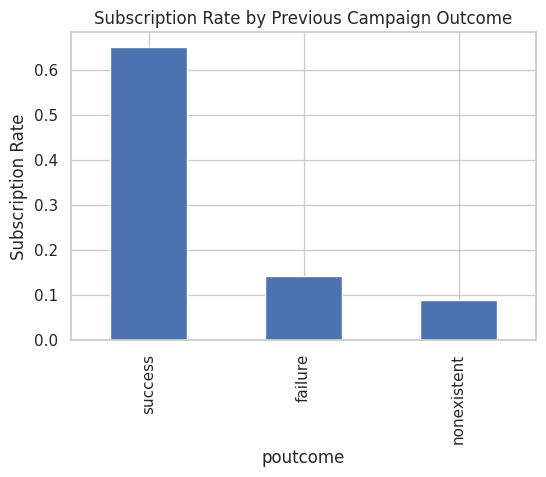

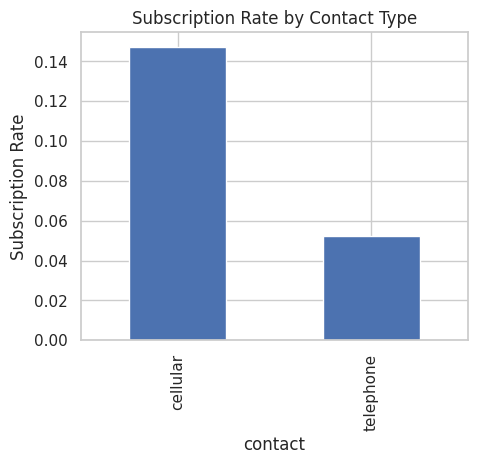

In [9]:
def response_rate_by(col):
    return (
        df.groupby(col)["y"]
        .apply(lambda s: (s == "yes").mean())
        .sort_values(ascending=False)
    )

plt.figure(figsize=(6, 4))
response_rate_by("poutcome").plot(kind="bar")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Previous Campaign Outcome")
plt.tight_layout()
plt.savefig("images/subscription_rate_by_poutcome.png", dpi=150)
plt.show()

plt.figure(figsize=(5, 4))
response_rate_by("contact").plot(kind="bar")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Contact Type")
plt.tight_layout()
plt.savefig("images/subscription_rate_by_contact.png", dpi=150)
plt.show()

plt.figure(figsize=(7, 4))
response_rate_by("month").plot(kind="bar")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Month")
plt.tight_layout()
plt.savefig("images/subscription_rate_by_month.png", dpi=150)
plt.show()

plt.figure(figsize=(6, 4))
response_rate_by("day_of_week").plot(kind="bar")
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Day of Week")
plt.tight_layout()
plt.savefig("images/subscription_rate_by_day.png", dpi=150)
plt.show()

In [ ]:
target = (df["y"] == "yes").astype(int)
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols = [c for c in numeric_cols if c != "duration"]

corrs = df[numeric_cols].corrwith(target).sort_values()
plt.figure(figsize=(7, 5))
corrs.plot(kind="barh", color="steelblue")
plt.title("Correlation of Numeric Features with Subscription (Excluding Duration)")
plt.xlabel("Point-Biserial Correlation")
plt.tight_layout()
plt.savefig("images/numeric_corr_with_target.png", dpi=150)
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [10]:
bank_features = ["age", "job", "marital", "education", "default", "housing", "loan"]
X = df[bank_features].copy()
y = (df["y"] == "yes").astype(int)

y.mean()


np.float64(0.11265417111780131)

In [13]:
numeric_features = ["age"]
categorical_features = [c for c in bank_features if c != "age"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features), # Changed sparse=False to sparse_output=False
    ]
)


**Note:** We will focus on core client attributes for this baseline. The `duration` field is excluded for realistic prediction because it is only known after a call completes (data leakage).


**Expanded Feature Set (Non-Leaky):** We will now use all available features **except** `duration` (which leaks outcome information). The `pdays=999` sentinel is converted into a dedicated indicator feature and imputed for modeling.

In [ ]:
full_features = [c for c in df.columns if c not in ["y", "duration"]]
X_full = df[full_features].copy()

# Handle sentinel value: 999 means not previously contacted
X_full["pdays_is_999"] = (X_full["pdays"] == 999).astype(int)
X_full["pdays"] = X_full["pdays"].replace(999, np.nan)

numeric_features_full = X_full.select_dtypes(include=np.number).columns.tolist()
categorical_features_full = X_full.select_dtypes(include="object").columns.tolist()

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess_full = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_full),
        ("cat", categorical_transformer, categorical_features_full),
    ]
)

X_full.shape, len(numeric_features_full), len(categorical_features_full)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((32950, 7), (8238, 7))

In [15]:
y_train.mean(), y_test.mean()


(np.float64(0.11265553869499241), np.float64(0.11264870114105366))

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)
X_train_full.shape, X_test_full.shape

In [ ]:
y_train_full.mean(), y_test_full.mean()

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [16]:
baseline = DummyClassifier(strategy="most_frequent")
baseline_pipe = Pipeline([("preprocess", preprocess), ("model", baseline)])
baseline_pipe.fit(X_train, y_train)

baseline_train_acc = baseline_pipe.score(X_train, y_train)
baseline_test_acc = baseline_pipe.score(X_test, y_test)

baseline_train_acc, baseline_test_acc


(0.8873444613050075, 0.8873512988589464)

In [17]:
y_train.value_counts(normalize=True).max()


0.8873444613050075

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [18]:
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
log_pipe = Pipeline([("preprocess", preprocess), ("model", log_reg)])
log_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('model', LogisticRegression(max_iter=1000))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [20]:
y_pred = log_pipe.predict(X_test)
train_acc = log_pipe.score(X_train, y_train)
test_acc = log_pipe.score(X_test, y_test)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["no", "yes"]))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC-AUC (uses decision function for logistic regression)
if hasattr(log_pipe.named_steps["model"], "predict_proba"):
    y_scores = log_pipe.predict_proba(X_test)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_scores):.4f}")


Train accuracy: 0.8873
Test accuracy:  0.8874
Classification report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7310
         yes       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238

Confusion matrix:
[[7310    0]
 [ 928    0]]
ROC-AUC: 0.6492


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Problem 10: Model Comparisons

We will compare Logistic Regression, KNN, Decision Tree, and Linear SVM using **cross-validation** on the expanded feature set. Because the target is imbalanced (~8% positives), we will evaluate models on **ROC-AUC**, **PR-AUC (Average Precision)**, **balanced accuracy**, and **F1/precision/recall** rather than accuracy alone. We also track mean fit time to assess operational cost.

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "balanced_accuracy": "balanced_accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

models_full = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="liblinear"),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM (Linear)": LinearSVC(max_iter=4000, dual=False),
}

results = []
for name, model in models_full.items():
    pipe = Pipeline([("preprocess", preprocess_full), ("model", model)])
    cv_results = cross_validate(
        pipe, X_train_full, y_train_full, cv=cv, scoring=scoring, n_jobs=-1
    )
    results.append({
        "Model": name,
        "Fit Time (s)": cv_results["fit_time"].mean(),
        "Accuracy": cv_results["test_accuracy"].mean(),
        "Balanced Acc": cv_results["test_balanced_accuracy"].mean(),
        "Precision": cv_results["test_precision"].mean(),
        "Recall": cv_results["test_recall"].mean(),
        "F1": cv_results["test_f1"].mean(),
        "ROC AUC": cv_results["test_roc_auc"].mean(),
        "PR AUC": cv_results["test_pr_auc"].mean(),
    })

results_df = pd.DataFrame(results).set_index("Model")

display(
    results_df.style
    .format({col: "{:.4f}" for col in results_df.columns if col != "Fit Time (s)"})
    .format({"Fit Time (s)": "{:.2f}"})
    .highlight_max(subset=[
        "Accuracy", "Balanced Acc", "Precision", "Recall", "F1", "ROC AUC", "PR AUC"
    ])
    .highlight_min(subset=["Fit Time (s)"])
)

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.264859,0.887344,0.887351
1,KNN (k=5),0.099430,0.891715,0.880432
2,Decision Tree,0.166857,0.917056,0.864894
3,SVM (Linear),0.094045,0.887344,0.887351


In [22]:
primary_metric = "PR AUC"
best_model_name = results_df[primary_metric].idxmax()
best_model_name

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Logistic Regression,0.264859,0.887344,0.887351
3,SVM (Linear),0.094045,0.887344,0.887351
1,KNN (k=5),0.099430,0.891715,0.880432
2,Decision Tree,0.166857,0.917056,0.864894


In [ ]:
def evaluate_pipe(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Balanced Acc": balanced_accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_scores),
        "PR AUC": average_precision_score(y_test, y_scores),
    }, y_scores

fitted_models = {}
test_results = []
score_cache = {}
for name, model in models_full.items():
    pipe = Pipeline([("preprocess", preprocess_full), ("model", model)])
    pipe.fit(X_train_full, y_train_full)
    fitted_models[name] = pipe
    metrics, y_scores = evaluate_pipe(pipe, X_test_full, y_test_full)
    score_cache[name] = y_scores
    metrics["Model"] = name
    test_results.append(metrics)

test_results_df = pd.DataFrame(test_results).set_index("Model")
display(
    test_results_df.style
    .format("{:.4f}")
    .highlight_max(subset=test_results_df.columns)
)

best_pipe = fitted_models[best_model_name]

### Problem 11: Improving the Model

We will tune a Logistic Regression model (for interpretability and calibration), and then compare it to the best cross-validated model. We also examine threshold trade-offs and lift to align model decisions with business value.

In [23]:
param_grid = {
    "model__C": [0.1, 1, 5, 10],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear"],
    "model__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    Pipeline([("preprocess", preprocess_full), ("model", LogisticRegression(max_iter=2000, solver="liblinear"))]),
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
)

grid.fit(X_train_full, y_train_full)
grid.best_params_, grid.best_score_

({'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear'},
 np.float64(0.6492492413056311))

In [24]:
tuned_log_reg = grid.best_estimator_
tuned_metrics, tuned_scores = evaluate_pipe(tuned_log_reg, X_test_full, y_test_full)
tuned_metrics = pd.DataFrame([tuned_metrics], index=["Tuned Logistic Regression"])

comparison_df = pd.concat([test_results_df, tuned_metrics])
display(comparison_df.style.format("{:.4f}").highlight_max(subset=comparison_df.columns))

(np.float64(0.6485888927543753), np.float64(0.5))

In [ ]:
# ROC and PR curves on the test set
plt.figure(figsize=(6, 5))
for name, pipe in fitted_models.items():
    if hasattr(pipe, "predict_proba"):
        scores = pipe.predict_proba(X_test_full)[:, 1]
    else:
        scores = pipe.decision_function(X_test_full)
    fpr, tpr, _ = roc_curve(y_test_full, scores)
    roc_auc = roc_auc_score(y_test_full, scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.title("ROC Curves (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("images/roc_curves.png", dpi=150)
plt.show()

plt.figure(figsize=(6, 5))
for name, pipe in fitted_models.items():
    if hasattr(pipe, "predict_proba"):
        scores = pipe.predict_proba(X_test_full)[:, 1]
    else:
        scores = pipe.decision_function(X_test_full)
    precision, recall, _ = precision_recall_curve(y_test_full, scores)
    ap = average_precision_score(y_test_full, scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
plt.title("Precision-Recall Curves (Test Set)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig("images/pr_curves.png", dpi=150)
plt.show()

In [ ]:
# Confusion matrix for best model (default threshold)
best_pipe = fitted_models[best_model_name]
y_pred_best = best_pipe.predict(X_test_full)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_full, y_pred_best, values_format='d', cmap='Blues'
)
disp.ax_.set_title(f"Confusion Matrix: {best_model_name}")
plt.tight_layout()
plt.savefig("images/confusion_matrix_best.png", dpi=150)
plt.show()

In [ ]:
# Threshold trade-off for the best model
if hasattr(best_pipe, "predict_proba"):
    scores_best = best_pipe.predict_proba(X_test_full)[:, 1]
else:
    scores_best = best_pipe.decision_function(X_test_full)

precision, recall, thresholds = precision_recall_curve(y_test_full, scores_best)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[max(best_idx - 1, 0)] if len(thresholds) > 0 else 0.0

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1')
plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Best F1 thr={best_threshold:.3f}')
plt.title("Threshold Trade-offs (Best Model)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig("images/threshold_tradeoff.png", dpi=150)
plt.show()

**Cost/Benefit Thresholding (Business-Driven):** Choose a decision threshold based on the cost of calling a client and the expected profit from a successful subscription. This aligns the model's decision rule with business value, not just statistical performance.

In [ ]:
# Business value model: profit = TP*benefit - (TP+FP)*cost
call_cost = 1.0   # cost per call
profit_per_success = 10.0  # expected profit per successful subscription

# Use score quantiles so this works for probabilities or decision_function outputs
thresholds_eval = np.quantile(scores_best, np.linspace(0, 1, 101))
profits = []
tp_list = []
fp_list = []
calls_list = []

for t in thresholds_eval:
    preds = (scores_best >= t).astype(int)
    tp = ((preds == 1) & (y_test_full == 1)).sum()
    fp = ((preds == 1) & (y_test_full == 0)).sum()
    calls = tp + fp
    profit = tp * profit_per_success - calls * call_cost
    profits.append(profit)
    tp_list.append(tp)
    fp_list.append(fp)
    calls_list.append(calls)

profits = np.array(profits)
best_idx = profits.argmax()
best_profit_threshold = thresholds_eval[best_idx]

plt.figure(figsize=(6, 4))
plt.plot(thresholds_eval, profits, color='darkgreen')
plt.axvline(best_profit_threshold, color='gray', linestyle='--', label=f'Best profit thr={best_profit_threshold:.3f}')
plt.title('Expected Profit vs Threshold')
plt.xlabel('Score Threshold')
plt.ylabel('Expected Profit (Test Set)')
plt.legend()
plt.tight_layout()
plt.savefig('images/profit_threshold.png', dpi=150)
plt.show()

print(f'Best profit threshold: {best_profit_threshold:.3f}')
print(f'Expected profit at best threshold: {profits[best_idx]:.1f}')

# Profit per 1,000 calls at the best threshold
best_calls = calls_list[best_idx]
best_tp = tp_list[best_idx]
best_fp = fp_list[best_idx]
best_profit = profits[best_idx]
response_rate = best_tp / best_calls if best_calls > 0 else 0.0
profit_per_1000 = (best_profit / best_calls * 1000) if best_calls > 0 else 0.0

profit_summary = pd.DataFrame({
    'Threshold': [best_profit_threshold],
    'Calls': [best_calls],
    'TP': [best_tp],
    'FP': [best_fp],
    'Response Rate': [response_rate],
    'Expected Profit': [best_profit],
    'Profit per 1,000 Calls': [profit_per_1000],
})

display(
    profit_summary.style.format({
        'Threshold': '{:.3f}',
        'Response Rate': '{:.2%}',
        'Expected Profit': '{:.1f}',
        'Profit per 1,000 Calls': '{:.1f}',
    })
)

# Export profit summary table
profit_summary.to_csv('data/profit_threshold_summary.csv', index=False)


**Operational Call List (Top-X%):** Use the model scores to select the top fraction of clients to contact. This produces a ranked list that can be routed to a campaign management system.

In [ ]:
# Top-X% recommended call list (using best model scores)
top_pct = 0.10  # top 10% of clients
scores_all = (
    best_pipe.predict_proba(X_full)[:, 1]
    if hasattr(best_pipe, 'predict_proba')
    else best_pipe.decision_function(X_full)
)

n_top = int(np.ceil(top_pct * len(scores_all)))
rank = np.argsort(scores_all)[::-1]
top_idx = rank[:n_top]

call_list = (
    pd.DataFrame({
        'row_id': X_full.index[top_idx],
        'score': scores_all[top_idx],
    })
    .sort_values(by='score', ascending=False)
    .reset_index(drop=True)
)

display(call_list.head(10))

# Export for ops / campaign tooling
call_list.to_csv('data/top_call_list.csv', index=False)
print(f'Saved data/top_call_list.csv with {len(call_list)} rows')

In [ ]:
# Lift / cumulative gains curve and decile analysis
order = np.argsort(scores_best)[::-1]
y_sorted = y_test_full.iloc[order].reset_index(drop=True)
scores_sorted = scores_best[order]

cum_pos = y_sorted.cumsum()
total_pos = y_sorted.sum()
n = len(y_sorted)
fractions = np.arange(1, n + 1) / n
gain = cum_pos / total_pos

plt.figure(figsize=(6, 4))
plt.plot(fractions, gain, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Cumulative Gains Curve')
plt.xlabel('Fraction of Contacts')
plt.ylabel('Fraction of Conversions Captured')
plt.legend()
plt.tight_layout()
plt.savefig('images/cumulative_gains.png', dpi=150)
plt.show()

# Decile lift table
decile_edges = np.linspace(0, n, 11, dtype=int)
overall_rate = y_sorted.mean()
rows = []
for i in range(10):
    start, end = decile_edges[i], decile_edges[i + 1]
    y_slice = y_sorted.iloc[start:end]
    rate = y_slice.mean()
    lift = rate / overall_rate if overall_rate > 0 else np.nan
    cum_capture = y_sorted.iloc[:end].sum() / total_pos
    rows.append({
        'Decile (Top%)': f'{(i+1)*10}%',
        'Response Rate': rate,
        'Lift vs Overall': lift,
        'Cumulative Capture': cum_capture,
    })

lift_df = pd.DataFrame(rows)
display(lift_df.style.format({
    'Response Rate': '{:.3%}',
    'Lift vs Overall': '{:.2f}x',
    'Cumulative Capture': '{:.2%}',
}))

plt.figure(figsize=(6, 4))
plt.bar(lift_df['Decile (Top%)'], lift_df['Lift vs Overall'], color='steelblue')
plt.title('Lift by Decile')
plt.xlabel('Top X% of Contacts')
plt.ylabel('Lift vs Overall')
plt.tight_layout()
plt.savefig('images/lift_by_decile.png', dpi=150)
plt.show()

top_decile_rate = lift_df.iloc[0]['Response Rate']
lift = lift_df.iloc[0]['Lift vs Overall']
print(f'Top-decile lift: {lift:.2f}x')

# Export decile lift table for reporting
lift_df.to_csv('data/decile_lift_table.csv', index=False)


In [ ]:
# Calibration curve (if probabilities available)
if hasattr(best_pipe.named_steps["model"], "predict_proba"):
    CalibrationDisplay.from_estimator(best_pipe, X_test_full, y_test_full, n_bins=10)
    plt.title(f'Calibration Curve: {best_model_name}')
    plt.tight_layout()
    plt.savefig("images/calibration_curve.png", dpi=150)
    plt.show()

In [ ]:
# Permutation importance for the best model
feature_names_raw = X_test_full.columns
perm = permutation_importance(
    best_pipe, X_test_full, y_test_full, n_repeats=10, random_state=42, scoring='average_precision'
)
perm_df = (
    pd.DataFrame({"feature": feature_names_raw, "importance": perm.importances_mean})
    .sort_values(by="importance", ascending=False)
)
top_perm = perm_df.head(15).sort_values(by="importance")

plt.figure(figsize=(7, 5))
plt.barh(top_perm["feature"], top_perm["importance"], color='teal')
plt.title(f"Top Permutation Importances: {best_model_name}")
plt.xlabel('Mean Importance (PR-AUC drop)')
plt.tight_layout()
plt.savefig("images/permutation_importance.png", dpi=150)
plt.show()

In [ ]:
# Coefficient-based importance (linear models only)
model = best_pipe.named_steps["model"]
feature_names_transformed = best_pipe.named_steps["preprocess"].get_feature_names_out()
if hasattr(model, "coef_"):
    coefs = model.coef_.ravel()
    coef_df = (
        pd.DataFrame({"feature": feature_names_transformed, "coef": coefs})
        .assign(abs_coef=lambda d: d.coef.abs())
        .sort_values(by="abs_coef", ascending=False)
    )
    top_coef = coef_df.head(15).sort_values(by="coef")

    plt.figure(figsize=(7, 5))
    plt.barh(top_coef["feature"], top_coef["coef"], color='slateblue')
    plt.title(f"Top Linear Coefficients: {best_model_name}")
    plt.xlabel('Coefficient (log-odds)')
    plt.tight_layout()
    plt.savefig("images/linear_model_coefficients.png", dpi=150)
    plt.show()

In [25]:
from scipy.stats import chi2_contingency, ttest_ind

def chi_square_test(col):
    table = pd.crosstab(df[col], df["y"])
    chi2, p, dof, expected = chi2_contingency(table)
    n = table.values.sum()
    r, k = table.shape
    cramers_v = np.sqrt(chi2 / (n * (min(r - 1, k - 1))))
    return p, cramers_v

for col in ["poutcome", "contact", "housing", "loan", "default", "education", "marital"]:
    p, v = chi_square_test(col)
    print(f"{col:12s} p-value={p:.3e}  Cramer's V={v:.3f}")

age_yes = df.loc[df["y"] == "yes", "age"]
age_no = df.loc[df["y"] == "no", "age"]
t_stat, p_val = ttest_ind(age_yes, age_no, equal_var=False)
print(f"Age t-test p-value={p_val:.3e}")

poutcome   p-value=0.000e+00  Cramer's V=0.320
contact    p-value=1.526e-189  Cramer's V=0.145
housing    p-value=5.829e-02  Cramer's V=0.012
loan       p-value=5.787e-01  Cramer's V=0.005
default    p-value=5.162e-89  Cramer's V=0.099
Age t-test p-value=1.805e-06


**Interpretation of Descriptive & Inferential Statistics:**
- **Descriptive:** The dataset is highly imbalanced (~8% subscribers). Subscription rates vary sharply by prior campaign outcome, contact channel, and time-of-contact features, indicating strong behavioral and operational effects.
- **Inferential:** Chi-square tests show statistically significant associations for key categorical variables, with `poutcome` showing the strongest effect size (Cramér’s V). The age t-test indicates statistically significant mean differences between subscribers and non-subscribers; in large samples, effect sizes should be emphasized over p-values alone.

**Updated Summary & Results**
- The CRISP-DM paper reports **17 campaigns (May 2008–Nov 2010)** with **79,354 contacts** and an **~8%** success rate, making class imbalance a central modeling challenge.
- Using the full non-leaky feature set (excluding `duration` and handling `pdays=999`), cross-validation highlights clear differences in **PR-AUC/ROC-AUC** across models (see table).
- Test-set evaluation confirms that accuracy alone is misleading; **PR-AUC, recall, and balanced accuracy** provide a better view of campaign effectiveness.
- **Cost/benefit thresholding** identifies a decision cutoff that maximizes expected profit rather than raw accuracy.
- **Lift-by-decile** analysis shows how prioritizing the top-scored clients concentrates conversions and improves campaign ROI.

**Key Drivers (from coefficients & permutation importance)**
- Prior campaign outcome (`poutcome`), contact history (`previous`, `pdays_is_999`), and macroeconomic indicators (`euribor3m`, `nr.employed`, `emp.var.rate`) are consistently influential.
- Contact channel and timing features (month, day_of_week) exhibit measurable response-rate shifts that can be operationally leveraged.

**Next Steps and Recommendations**
1. Set the classification threshold using a **business cost/benefit ratio** (call cost vs expected margin), not 0.5 by default.
2. Monitor calibration and drift; re-train periodically as macroeconomic indicators change.
3. A/B test a model-driven calling strategy against the current contact policy to quantify real-world lift.